In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_csv('combined_raw_data.csv',low_memory=False,index_col=0)

# Sweat Data

## Get Blanks Values

In [8]:
# get blanks
blanks = []
for i in raw.index:
    tmp_sample_type = str(raw.loc[i,'sample_type'])
    # we want blanks, but not plasma blanks
    if 'blank' in tmp_sample_type and 'plasma' not in tmp_sample_type:
        blanks.append(i)
blank = raw.loc[blanks,:]

# get samples of interest
fulls = []
for i in raw.index:
    tmp_sample_type = str(raw.loc[i,'sample_type'])
    if tmp_sample_type in ['swab_skin of back','swab_head or neck skin']:
#         print(tmp_sample_type)
        fulls.append(i)
full = raw.loc[fulls,:]
full['timepoint_hour'] = full['timepoint_hour'].astype(float)
full = full.sort_values(['subject_id','sample_type','timepoint_hour'])
# the rule is: If max(AUC(feature) from blanks) * 5 >= min(AUC(feature) from sample), then the feature is discarded
blank_max = np.max(blank.iloc[:,5:])
blank_5max = blank_max*5

In [9]:
def get_mz_rt(feature):
    tmp_mz, tmp_rt = raw.loc[['m/z','RT'],feature].values
    return tmp_mz, tmp_rt

## Donor-Wise Removal of Noisy Features

In [10]:
rt_tol =  .5 # +-min
mz_tol = 2.5 # +-ppm
all_features = raw.columns.values[5:]
all_mz = raw.loc['m/z',:].values[5:].astype(float)
all_rt = raw.loc['RT',:].values[5:].astype(float)

EXCL = {}
debug = False
for donor in full['subject_id'].unique():
    EXCL[donor] = {}
    for location in ['swab_skin of back','swab_head or neck skin']:
        n = 0
        whitelist = []
        blacklist = []
        print(donor,location)
        tmpfull = full.loc[(full['subject_id']==donor)&(full['sample_type']==location),:]
        for feature in tmpfull.columns[5:]:
            n += 1

            tmp_mz, tmp_rt = get_mz_rt(feature)
            close_mz = np.isclose(all_mz,tmp_mz,atol=mz_tol*tmp_mz*1e-6)
            close_rt = np.isclose(all_rt,tmp_rt,atol=rt_tol)
            both_true = np.all(np.array([close_mz,close_rt]),axis=0)
            tmp_sample_med = np.min(tmpfull.loc[:,feature].values)
            tmp_blank_5max = blank_5max[all_features[both_true]]
            if debug:
                print(feature,'(mz, rt)',get_mz_rt(feature))
                print('Nr Similar Compounds',np.sum(both_true))
        #         print('Sample Min          ',tmp_sample_min)
        #         print('Blank 5Max          ',tmp_blank_5max)
                if tmp_sample_min > 0:
                    print('Ratio of 5*MAX(blanks)/MEDIAN(samples)')
                    print(tmp_blank_5max/tmp_sample_med)
            if np.any(tmp_blank_5max < tmp_sample_med):
                whitelist.append(feature)
                if debug:
                    print('Whitelisted',feature)
            else:
                blacklist.append(feature)
                if debug:
                    print('Blacklisted',feature)
            if debug:
                print('------------------')
    #         if n%1000 == 0:
    #             print('{:.0f}%'.format(n/len(tmpfull.columns[3:])*100))
        #     if n == 111:
        #         break
        print('Nr. Blacklisted',len(blacklist))
        print('Nr. Whitelisted',len(whitelist))
        EXCL[donor][location] = [whitelist,blacklist]

191001 swab_skin of back
Nr. Blacklisted 7286
Nr. Whitelisted 6240
191001 swab_head or neck skin
Nr. Blacklisted 13489
Nr. Whitelisted 37
191002 swab_skin of back
Nr. Blacklisted 6757
Nr. Whitelisted 6769
191002 swab_head or neck skin
Nr. Blacklisted 6898
Nr. Whitelisted 6628
191003 swab_skin of back
Nr. Blacklisted 6289
Nr. Whitelisted 7237
191003 swab_head or neck skin
Nr. Blacklisted 6647
Nr. Whitelisted 6879
191004 swab_skin of back
Nr. Blacklisted 6712
Nr. Whitelisted 6814
191004 swab_head or neck skin
Nr. Blacklisted 6673
Nr. Whitelisted 6853
191005 swab_skin of back
Nr. Blacklisted 6693
Nr. Whitelisted 6833
191005 swab_head or neck skin
Nr. Blacklisted 6831
Nr. Whitelisted 6695
191007 swab_skin of back
Nr. Blacklisted 7107
Nr. Whitelisted 6419
191007 swab_head or neck skin
Nr. Blacklisted 7307
Nr. Whitelisted 6219
191008 swab_skin of back
Nr. Blacklisted 7090
Nr. Whitelisted 6436
191008 swab_head or neck skin
Nr. Blacklisted 6977
Nr. Whitelisted 6549
191009 swab_skin of back
Nr.

## Plot and Write Out Data

In [11]:
def calculate_pqn(data):
    # implemented according to http://dx.doi.org/10.1016/j.chroma.2014.08.050
    ref = np.median(data,axis=1) 
    div = np.divide(data,ref[:,None])
    pqn = np.median(div,axis=0)
    return pqn

def plot_identiy(*some_arrays):
    tmp_min = np.min(some_arrays)
    tmp_max = np.max(some_arrays)
    plt.plot([tmp_min,tmp_max],[tmp_min,tmp_max],'k--',label='Identity')
    
def cv(array):
    return np.std(array)/np.mean(array)

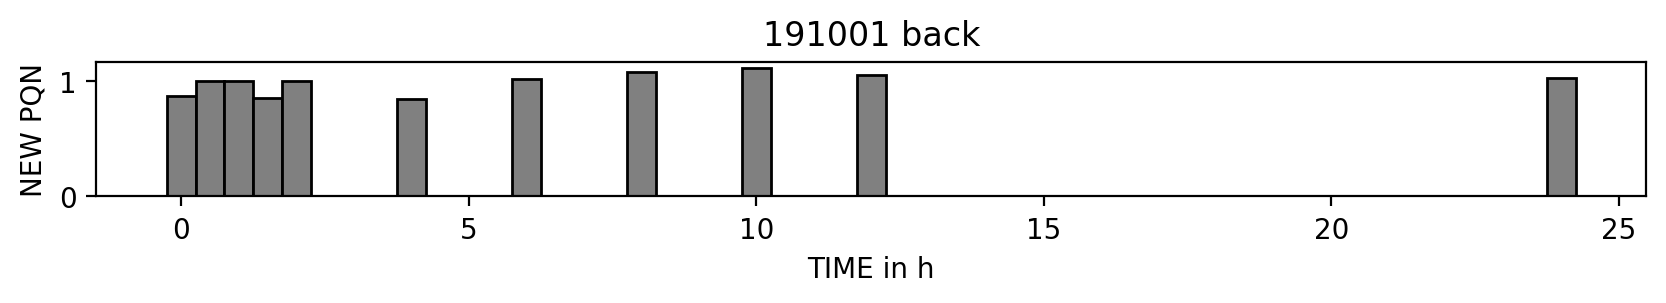

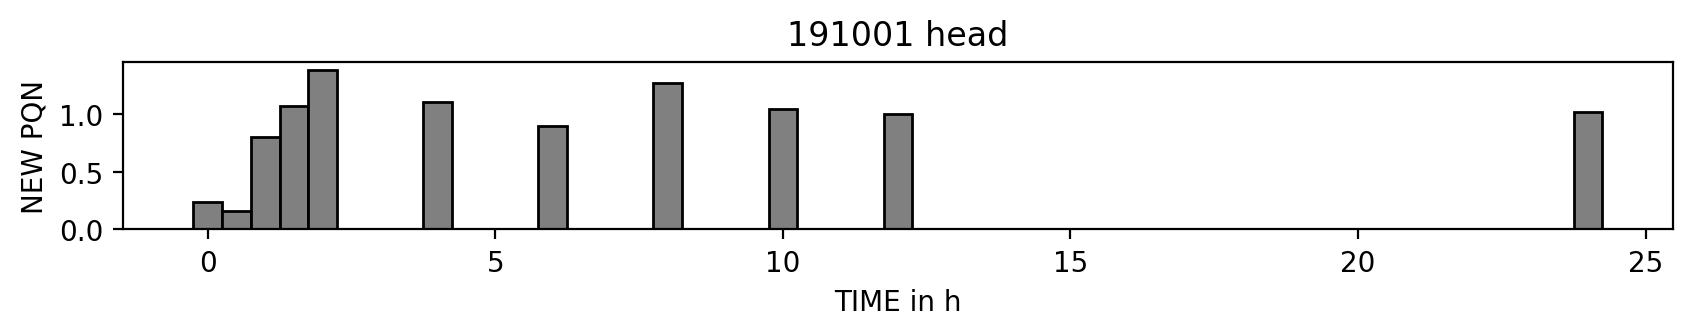

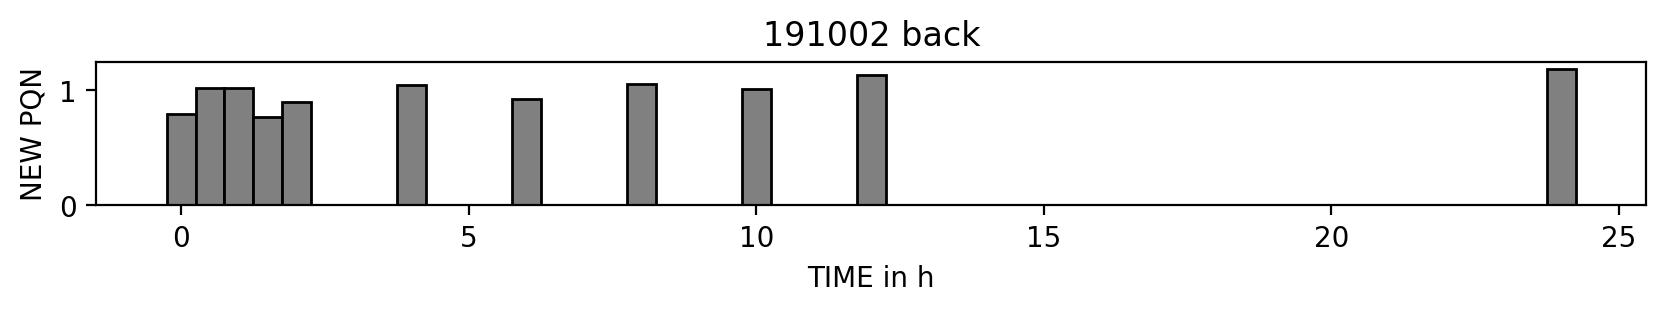

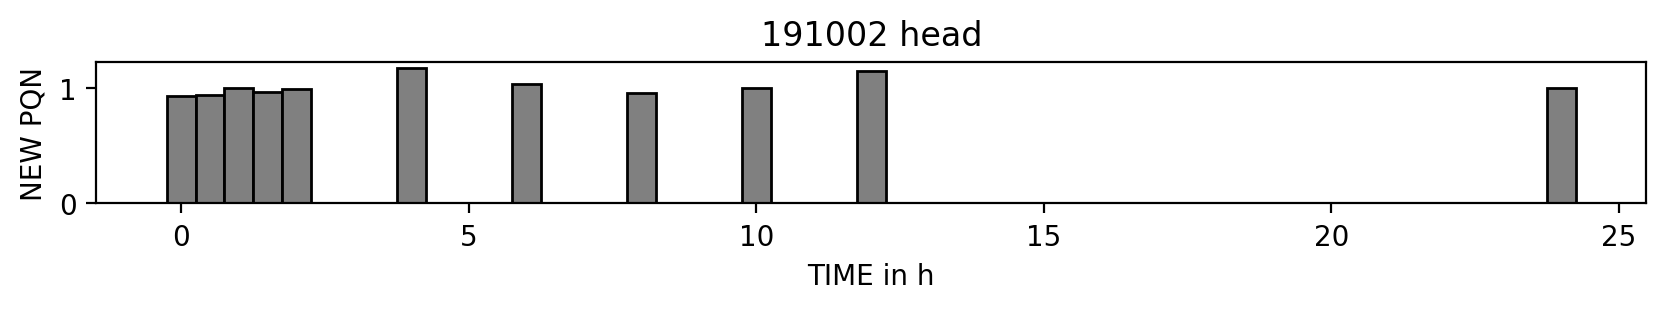

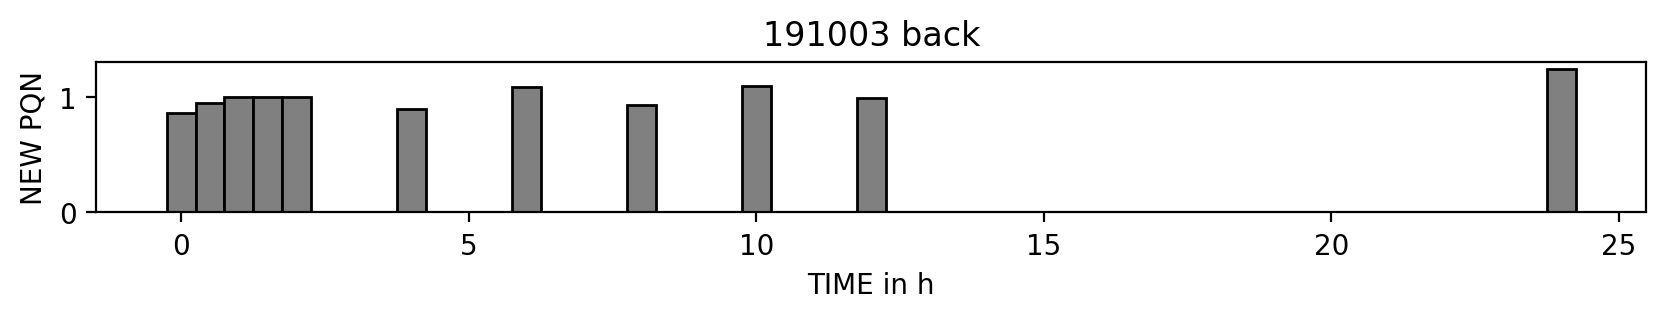

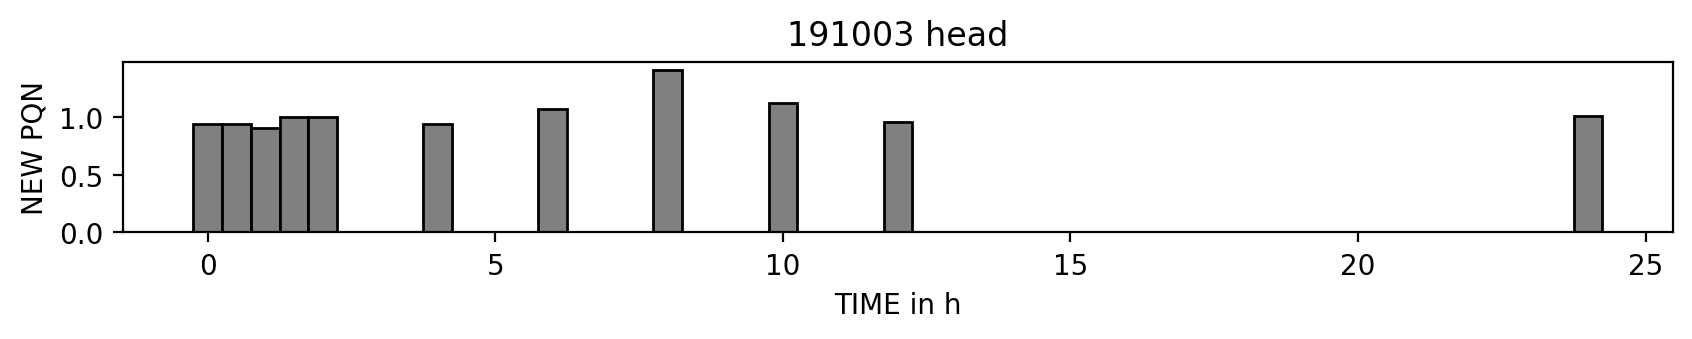

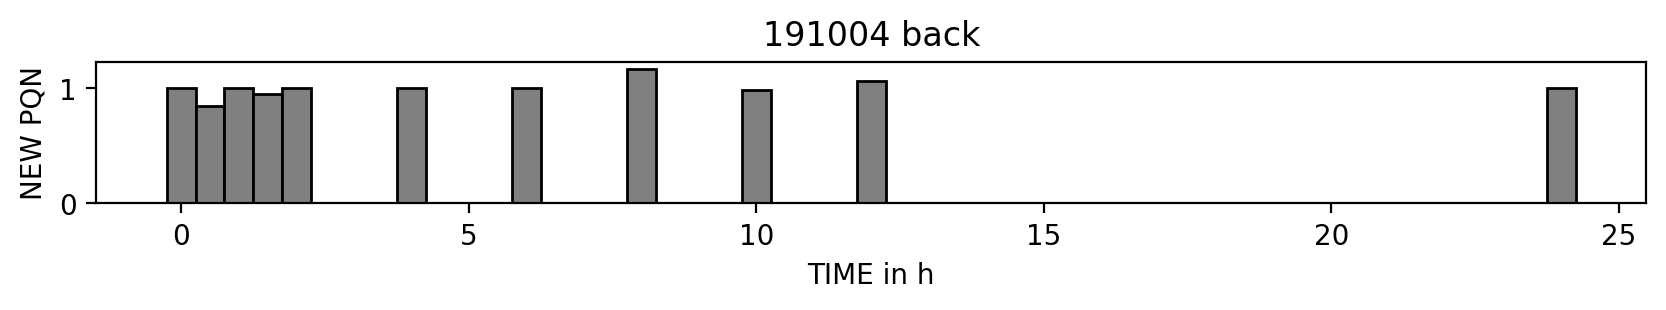

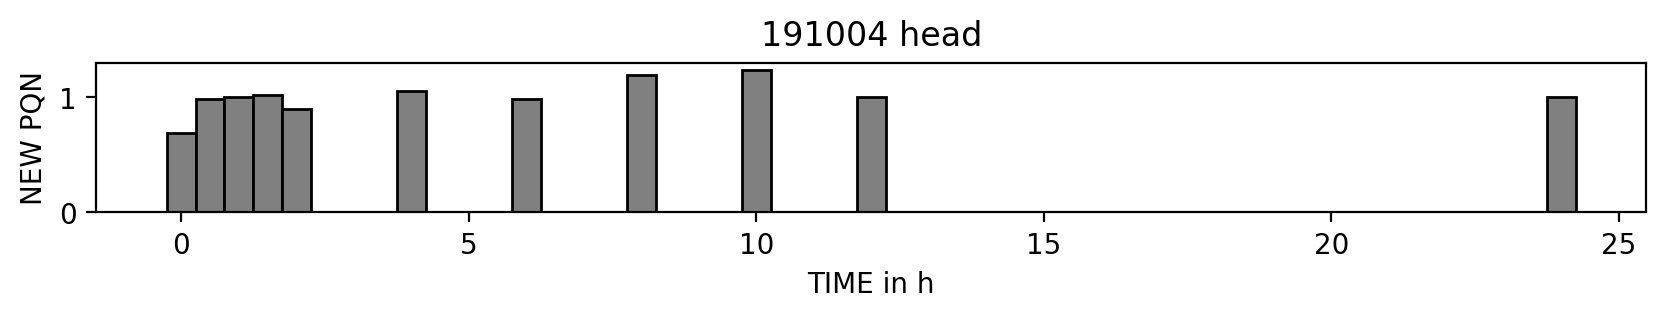

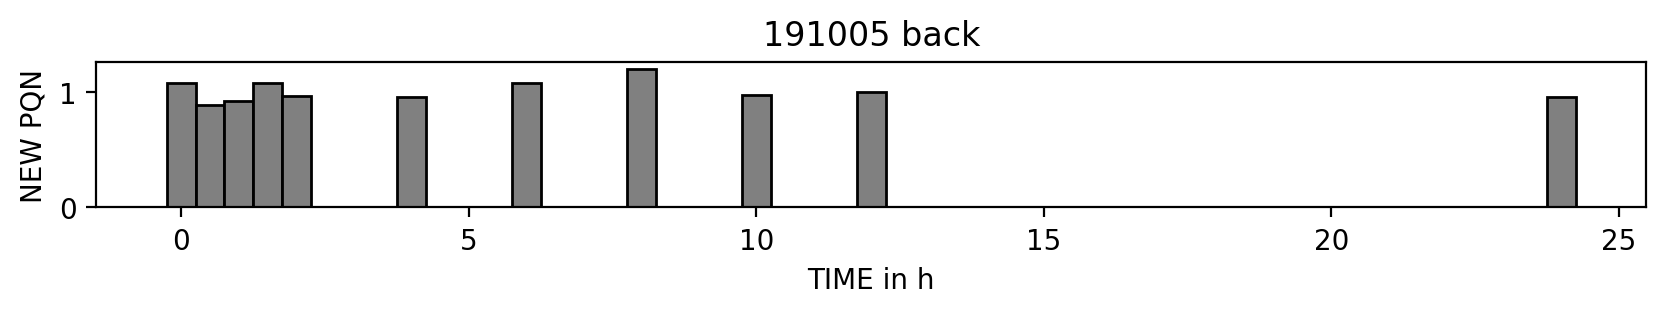

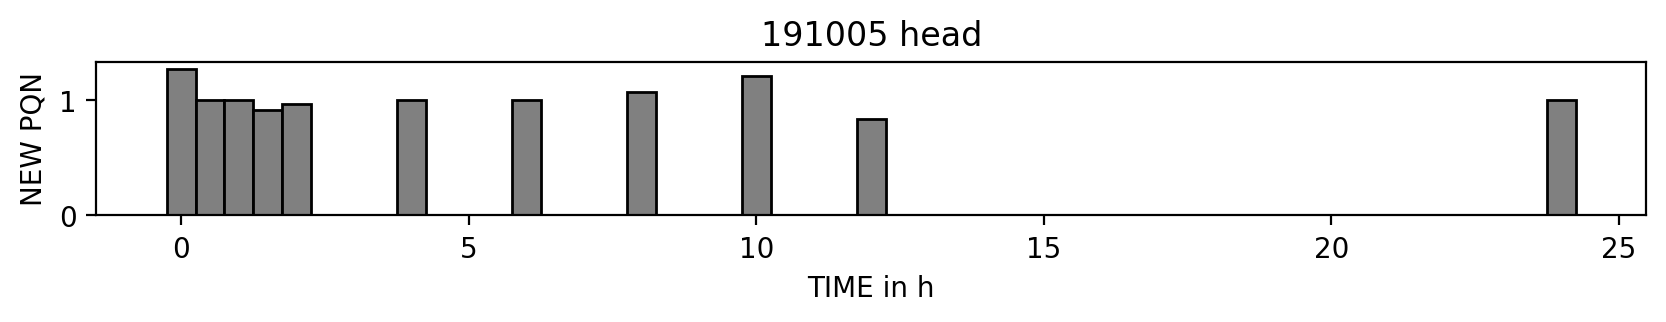

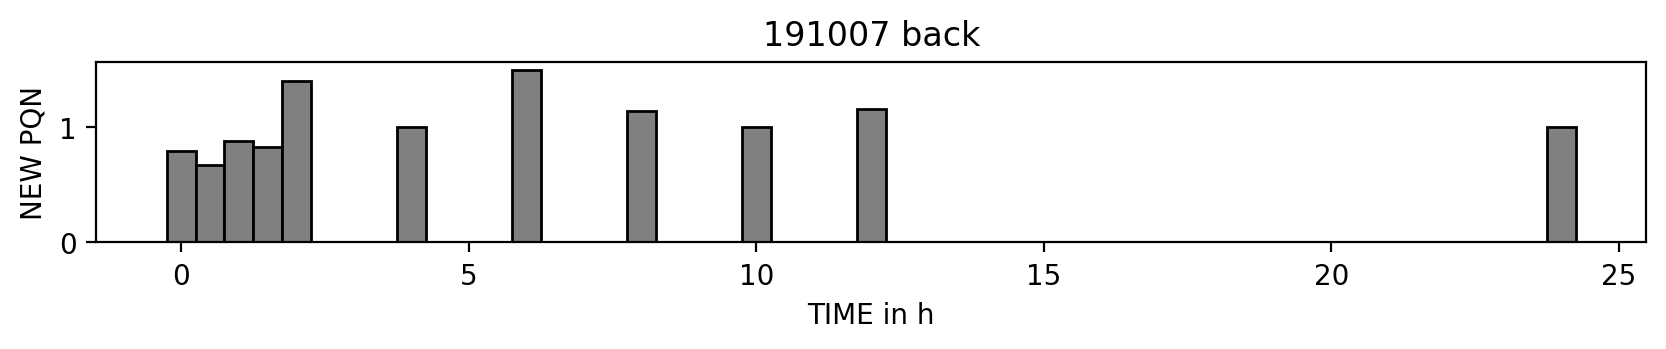

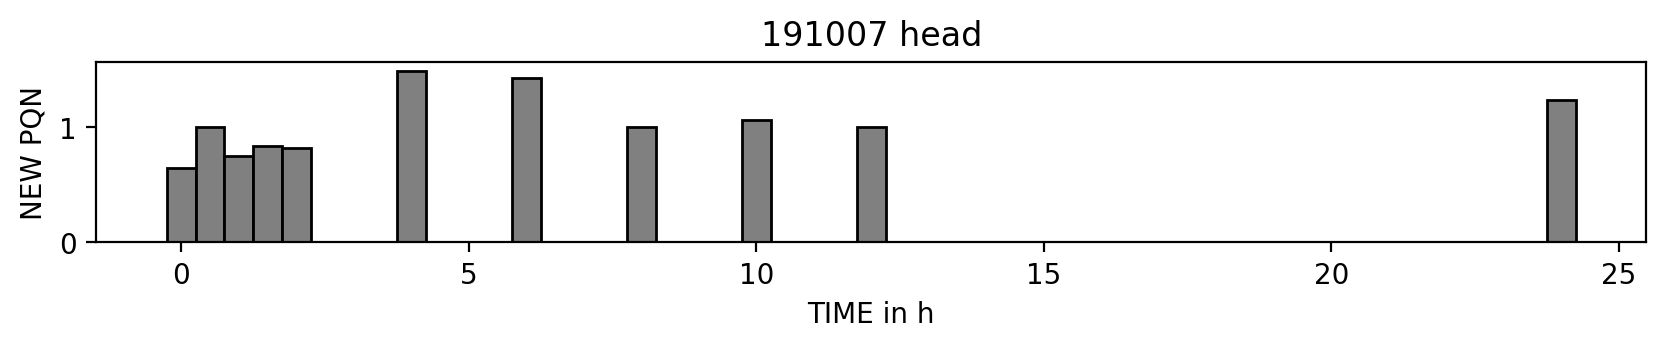

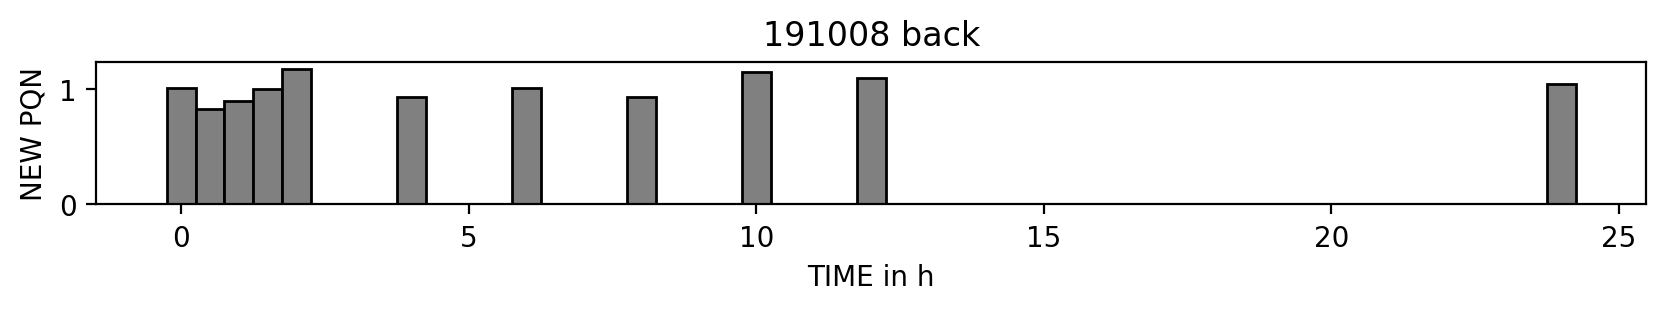

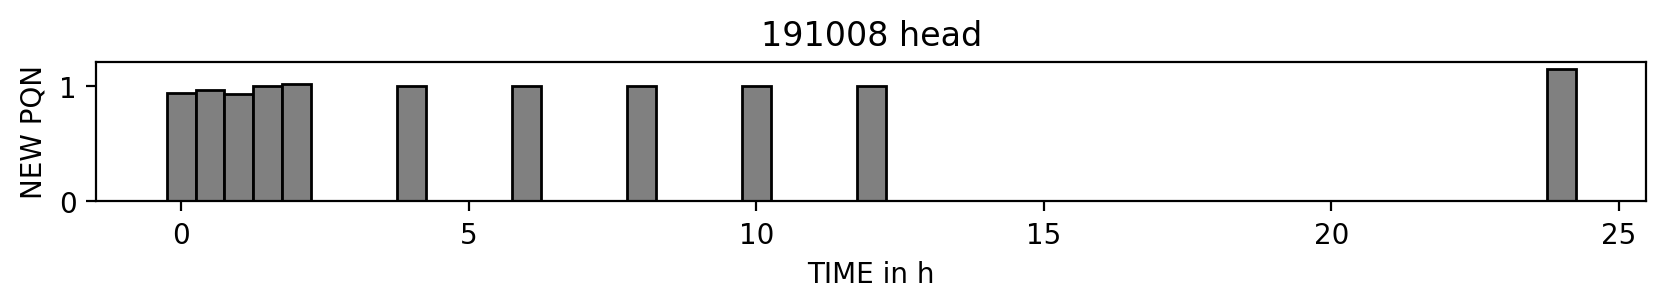

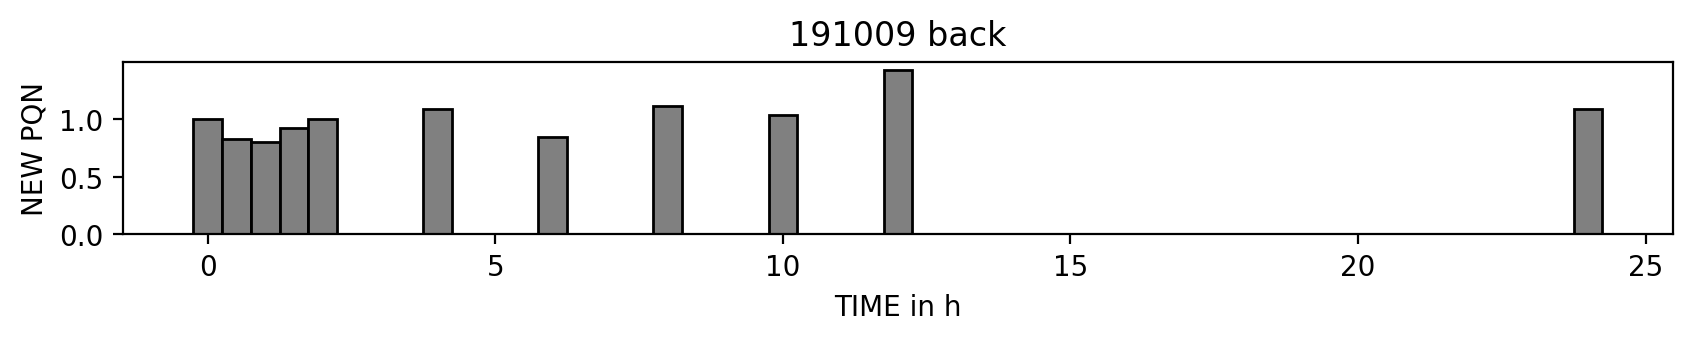

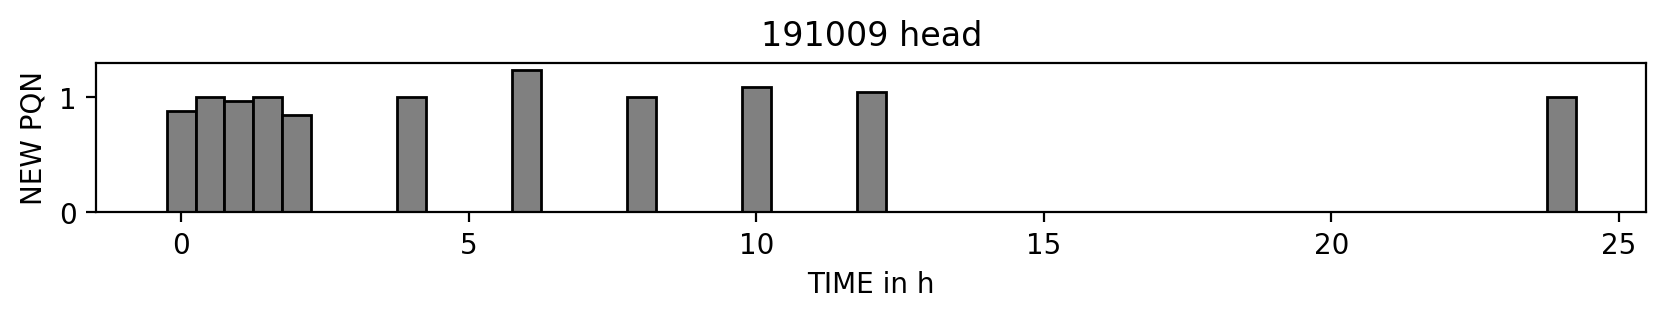

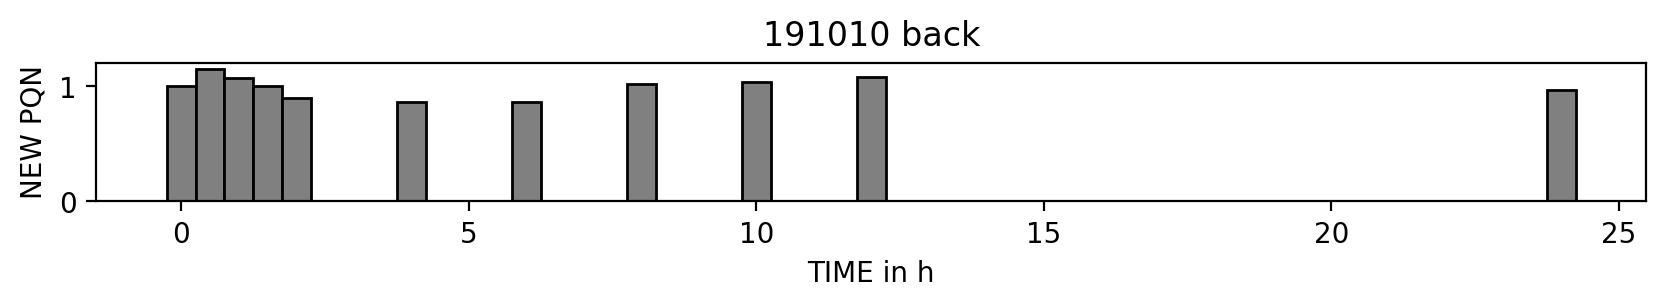

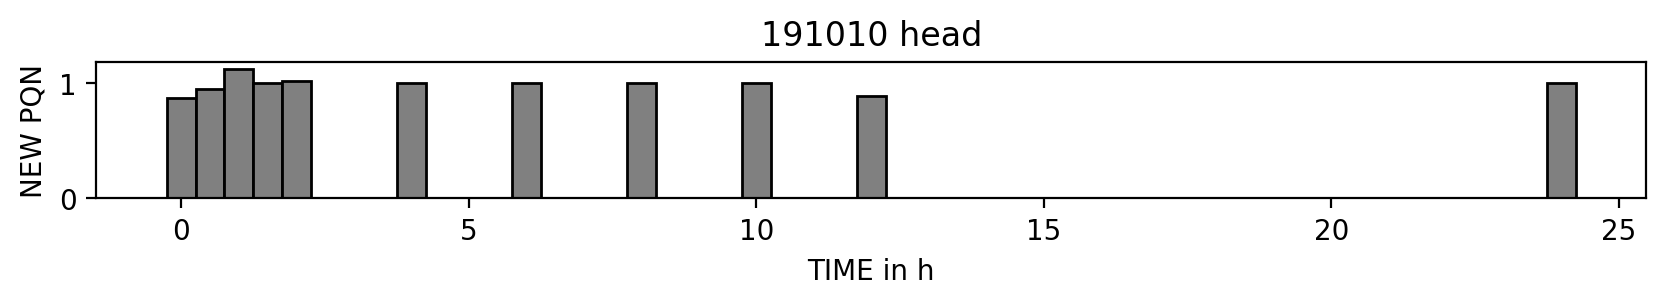

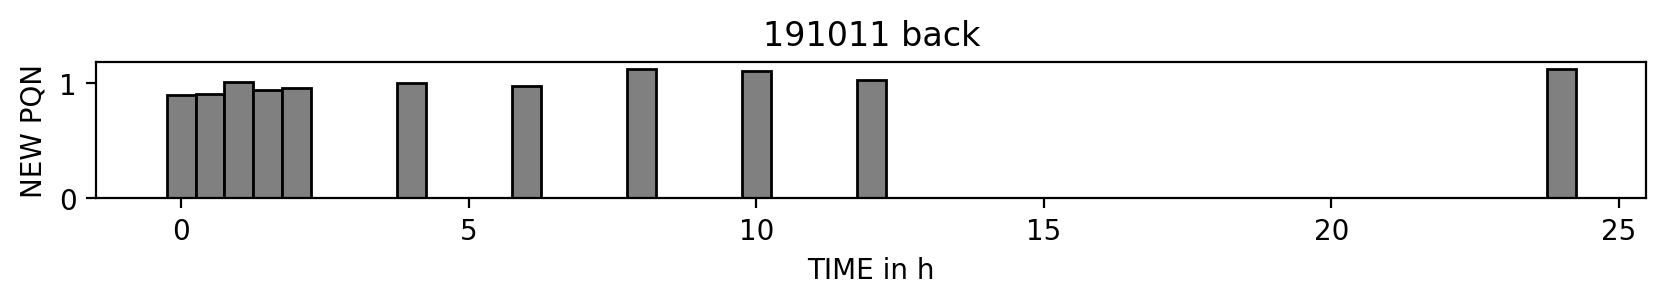

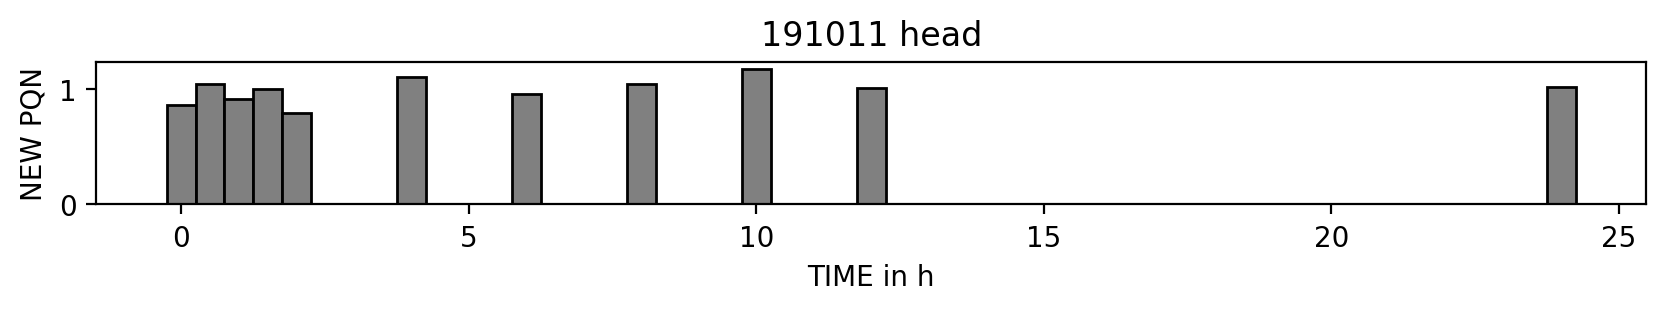

In [16]:
locname = {'swab_skin of back':'back','swab_head or neck skin':'head'}
meta_names_short  = {'feature_439':'DPH',
                     'feature_396':'NDM-DPH',
                     'feature_345':'DPH-N-glucuronide',
                     'feature_634':'DPH-N-glucose'}
reversed_meta_names_short = {value : key for (key, value) in meta_names_short.items()}
targeted_features = ['DPH', 'NDM-DPH', 'DPH-N-glucuronide', 'DPH-N-glucose']
targeted_features.reverse()

for donor in full['subject_id'].unique():
    for location in ['swab_skin of back','swab_head or neck skin']:
        tmpfull = full.loc[(full['subject_id']==donor)&(full['sample_type']==location),:]
        new_pqn = calculate_pqn(tmpfull.loc[:,EXCL[donor][location][0]].values.T)

        # write out data
        norm_df = tmpfull.copy()
        norm_df.insert(5,'PQN',new_pqn)
        for tf in targeted_features:
            norm_df.insert(6,tf,tmpfull[reversed_meta_names_short[tf]].values)
        norm_df.index = range(norm_df.shape[0])
        norm_df.to_csv(f'data/{donor}_{locname[location]}.csv')

        # begin figure
        plt.figure(dpi=200,figsize=(10,3))
        plt.subplot(111,aspect=2)
        plt.title(f'{donor} {locname[location]}')
        plt.bar(tmpfull['timepoint_hour'].values,new_pqn,color='grey',edgecolor='k',width=.5)
        plt.ylabel('NEW PQN')
        plt.xlabel('TIME in h')
        plt.show()

# Plasma Data

## Get Blank Values

In [17]:
# get blanks
plasma_blanks = []
for i in raw.index:
    tmp_sample_type = str(raw.loc[i,'sample_type'])
    if 'blank' in tmp_sample_type and 'derm' not in tmp_sample_type and 'skin' not in i:
#         print(raw.loc[i,'sample_type'])
        plasma_blanks.append(i)
plasma_blank = raw.loc[plasma_blanks,:]

# get samples of interest
plasma_fulls = []
for i in raw.index:
    tmp_sample_type = str(raw.loc[i,'sample_type'])
    if tmp_sample_type in ['plasma']:
#         print(tmp_sample_type)
        plasma_fulls.append(i)
plasma_full = raw.loc[plasma_fulls,:]
plasma_full['timepoint_hour'] = plasma_full['timepoint_hour'].astype(float)
plasma_full = plasma_full.sort_values(['subject_id','sample_type','timepoint_hour'])
# the rule is: If max(AUC(feature) from blanks) * 5 >= min(AUC(feature) from sample), then the feature is discarded
blank_max = np.max(blank.iloc[:,5:])
blank_5max = blank_max*5

## Donor-Wise Removal of Noisy Features

In [19]:
rt_tol =  .5 # +-min
mz_tol = 2.5 # +-ppm
all_features = raw.columns.values[5:]
all_mz = raw.loc['m/z',:].values[5:].astype(float)
all_rt = raw.loc['RT',:].values[5:].astype(float)

EXCL = {}
debug = False
for donor in full['subject_id'].unique():
    EXCL[donor] = {}
    for location in ['plasma']:
        n = 0
        whitelist = []
        blacklist = []
        print(donor,location)
        tmpfull = plasma_full.loc[(plasma_full['subject_id']==donor)&(plasma_full['sample_type']==location),:]
        for feature in tmpfull.columns[5:]:
            n += 1

            tmp_mz, tmp_rt = get_mz_rt(feature)
            close_mz = np.isclose(all_mz,tmp_mz,atol=mz_tol*tmp_mz*1e-6)
            close_rt = np.isclose(all_rt,tmp_rt,atol=rt_tol)
            both_true = np.all(np.array([close_mz,close_rt]),axis=0)
            tmp_sample_med = np.min(tmpfull.loc[:,feature].values)
            tmp_blank_5max = blank_5max[all_features[both_true]]
            if debug:
                print(feature,'(mz, rt)',get_mz_rt(feature))
                print('Nr Similar Compounds',np.sum(both_true))
        #         print('Sample Min          ',tmp_sample_min)
        #         print('Blank 5Max          ',tmp_blank_5max)
                if tmp_sample_min > 0:
                    print('Ratio of 5*MAX(blanks)/MEDIAN(samples)')
                    print(tmp_blank_5max/tmp_sample_med)
            if np.any(tmp_blank_5max < tmp_sample_med):
                whitelist.append(feature)
                if debug:
                    print('Whitelisted',feature)
            else:
                blacklist.append(feature)
                if debug:
                    print('Blacklisted',feature)
            if debug:
                print('------------------')
    #         if n%1000 == 0:
    #             print('{:.0f}%'.format(n/len(tmpfull.columns[3:])*100))
        #     if n == 111:
        #         break
        print('Nr. Blacklisted',len(blacklist))
        print('Nr. Whitelisted',len(whitelist))
        EXCL[donor][location] = [whitelist,blacklist]

191001 plasma
Nr. Blacklisted 12575
Nr. Whitelisted 951
191002 plasma
Nr. Blacklisted 12283
Nr. Whitelisted 1243
191003 plasma
Nr. Blacklisted 12613
Nr. Whitelisted 913
191004 plasma
Nr. Blacklisted 12452
Nr. Whitelisted 1074
191005 plasma
Nr. Blacklisted 12574
Nr. Whitelisted 952
191007 plasma
Nr. Blacklisted 12395
Nr. Whitelisted 1131
191008 plasma
Nr. Blacklisted 12399
Nr. Whitelisted 1127
191009 plasma
Nr. Blacklisted 12664
Nr. Whitelisted 862
191010 plasma
Nr. Blacklisted 12590
Nr. Whitelisted 936
191011 plasma
Nr. Blacklisted 12549
Nr. Whitelisted 977


## Plot and Write Out Data

(11, 966)


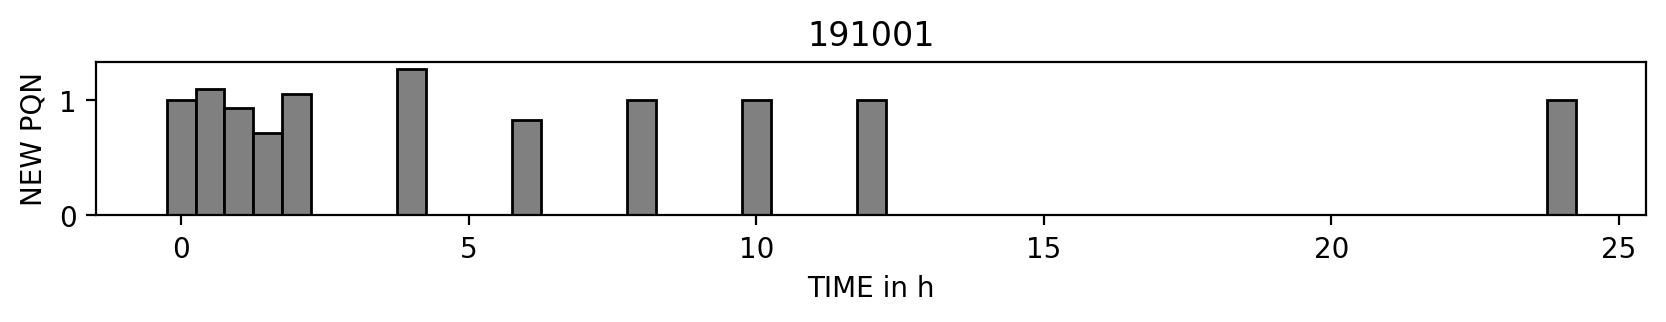

(10, 1258)


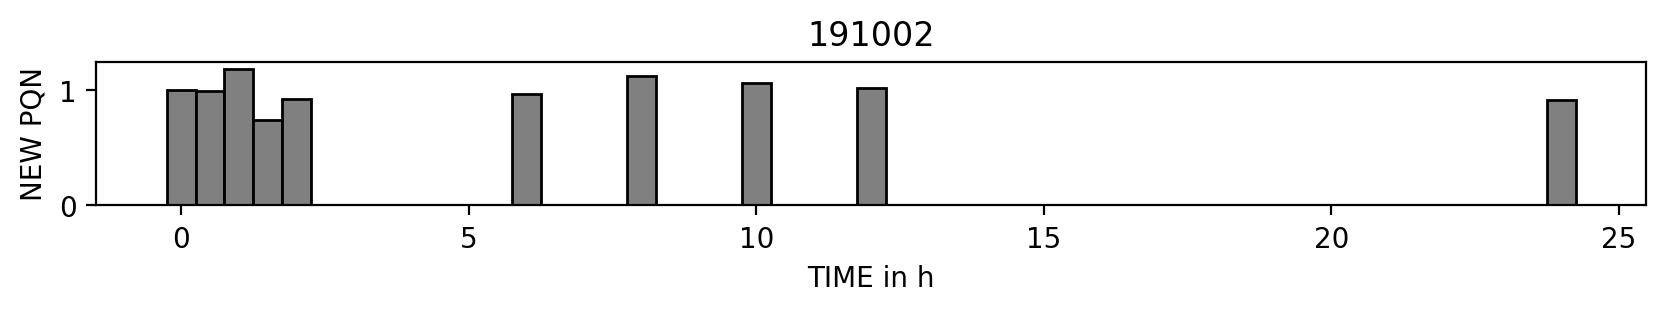

(11, 928)


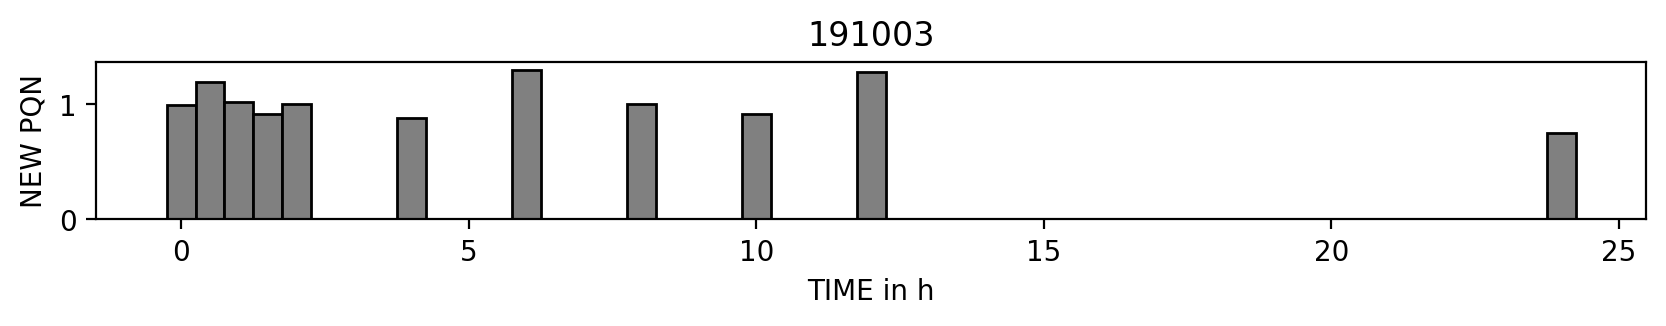

(11, 1089)


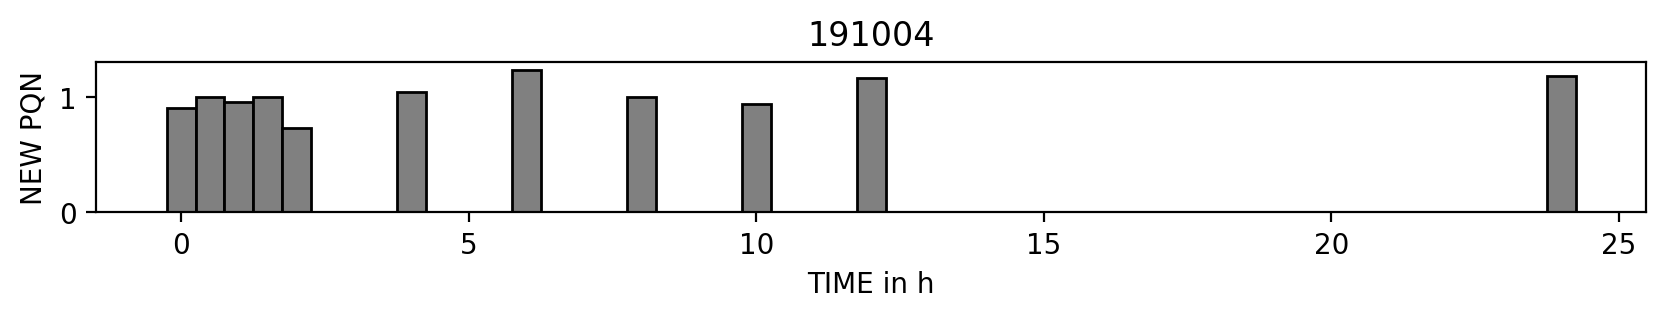

(11, 967)


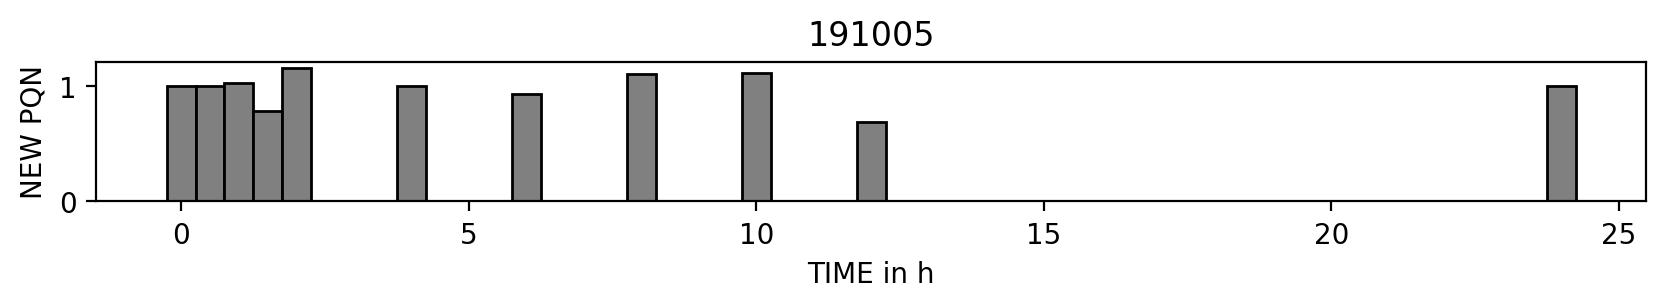

(12, 1146)


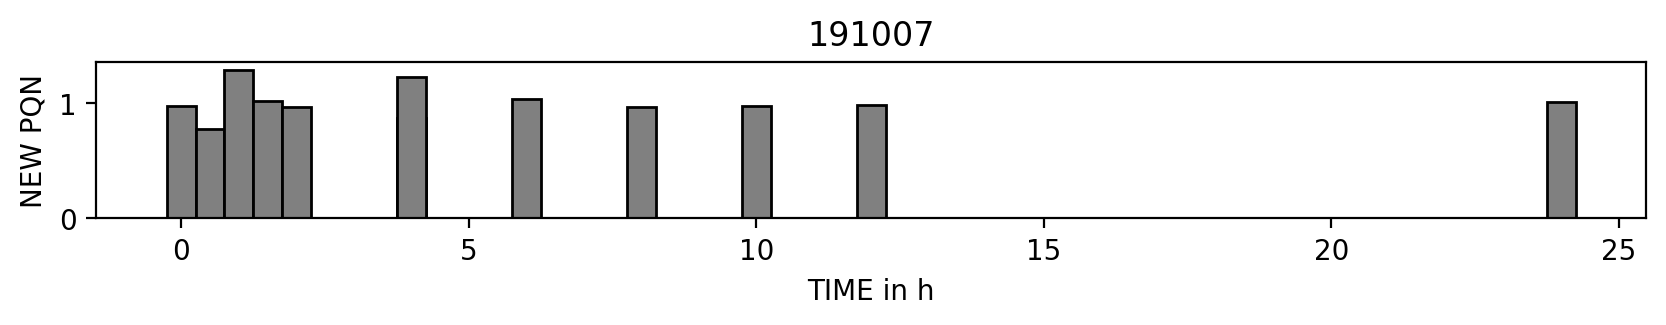

(11, 1142)


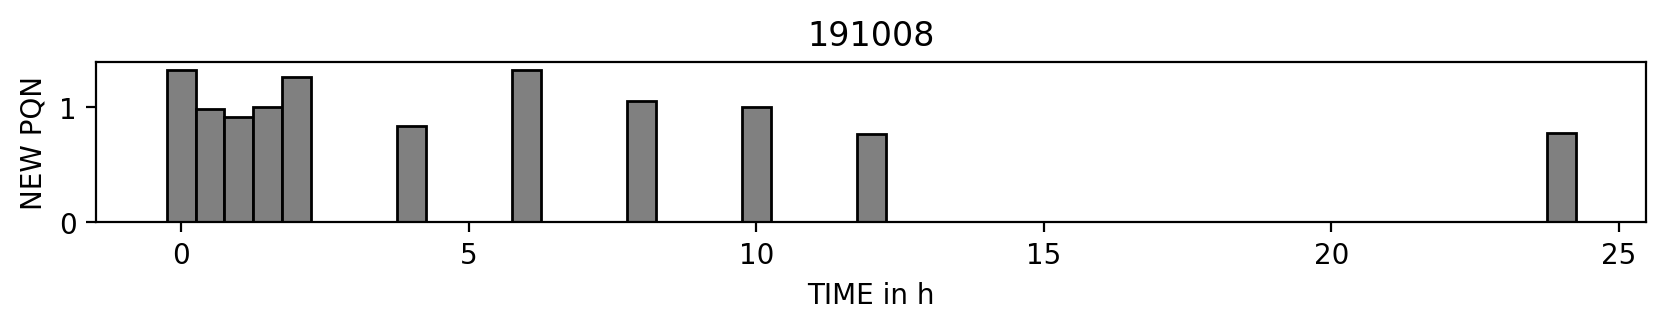

(11, 877)


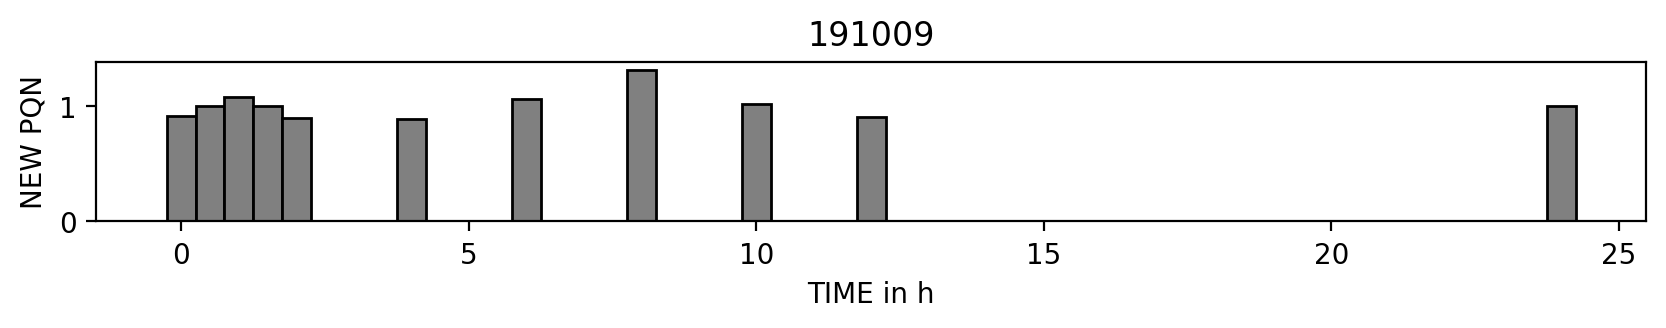

(11, 951)


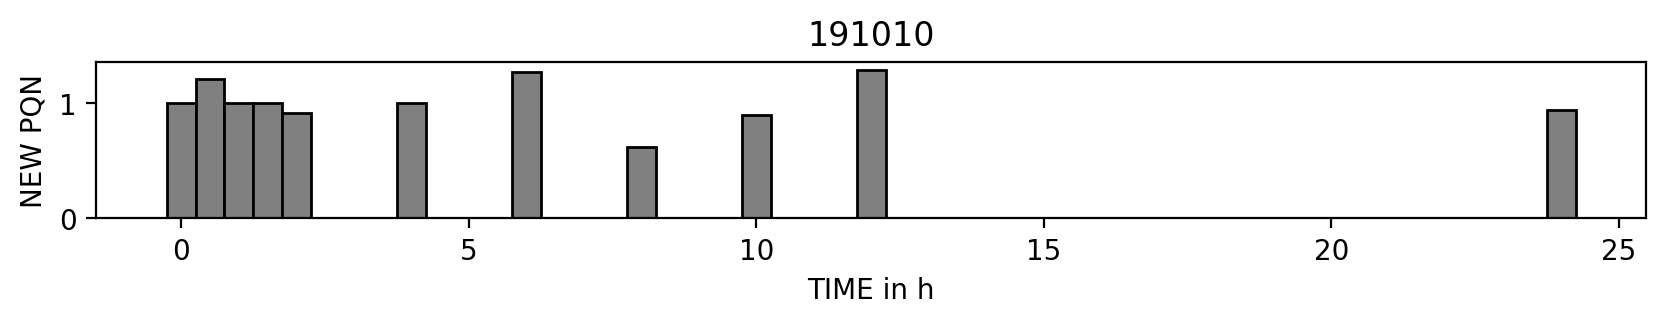

(11, 992)


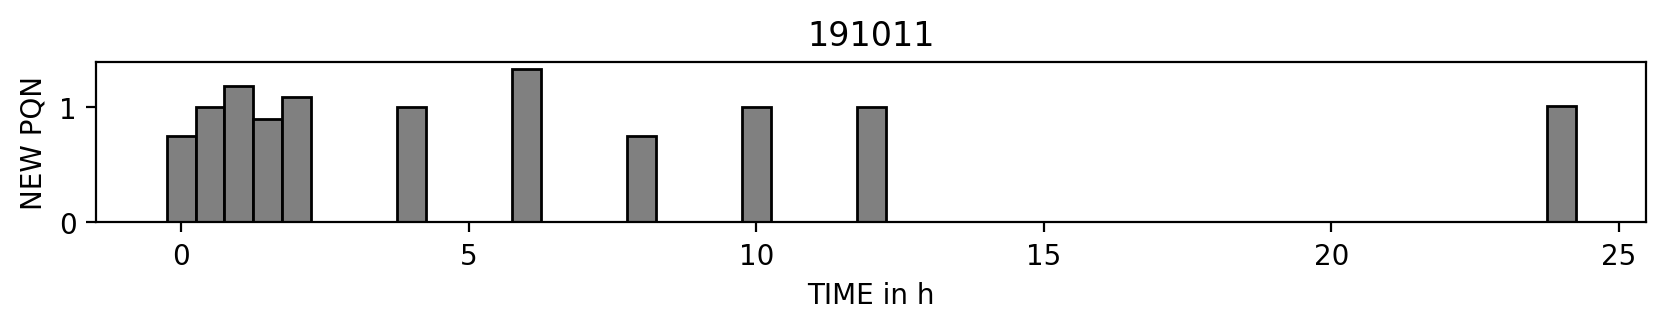

In [21]:
locname = {'swab_skin of back':'back','swab_head or neck skin':'head','plasma':'plasma'}
targeted_features = ['DPH', 'NDM-DPH', 'DPH-N-glucuronide', 'DPH-N-glucose']
targeted_features.reverse()

for donor in plasma_full['subject_id'].unique():
    for location in ['plasma']:
        tmpfull = plasma_full.loc[(plasma_full['subject_id']==donor)&(plasma_full['sample_type']==location),:]
        new_pqn = calculate_pqn(tmpfull.loc[:,EXCL[donor][location][0]].values.T)
        
        # write out data
        norm_df = tmpfull.loc[:,list(tmpfull.columns[:10])+EXCL[donor][location][0]].copy()
        norm_df.insert(5,'PQN',new_pqn)
        for tf in targeted_features:
            norm_df.insert(6,tf,tmpfull[reversed_meta_names_short[tf]].values)
        norm_df.index = range(norm_df.shape[0])
        norm_df.to_csv(f'data/{donor}_{locname[location]}.csv')
        print(norm_df.shape)
        # begin figure
        plt.figure(dpi=200,figsize=(10,3))
        plt.subplot(111,aspect=2)
        plt.title(donor)
        plt.bar(tmpfull['timepoint_hour'].values,new_pqn,color='grey',edgecolor='k',width=.5)
        plt.ylabel('NEW PQN')
        plt.xlabel('TIME in h')
        plt.show()
#         break
#     break